In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from scipy.signal import savgol_filter, detrend, find_peaks
from scipy.special import voigt_profile, wofz
from scipy.stats import cauchy, norm
from sklearn.ensemble import IsolationForest
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from lmfit.models import ExponentialModel, VoigtModel, ConstantModel

In [3]:
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut, rubberband_baseline_cor

In [4]:
# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

<Axes: >

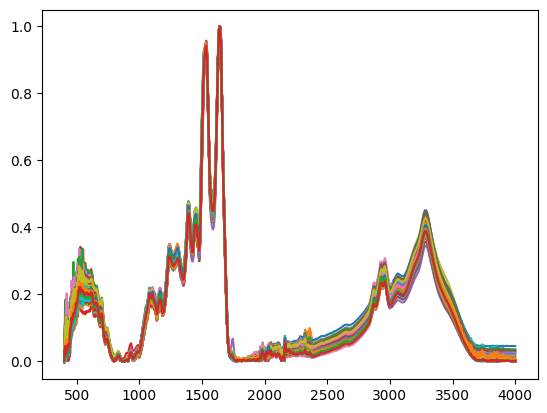

In [5]:
domain = pd.read_csv('../data/domain.csv')
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

df = df.drop(columns='years')

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
#X = X.apply(lambda row: row / row.max(), axis=1)
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=1)).T
X = X.apply(lambda row: row / row.max(), axis=1)
#X = X_raw.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

(1000.0, 1700.0)

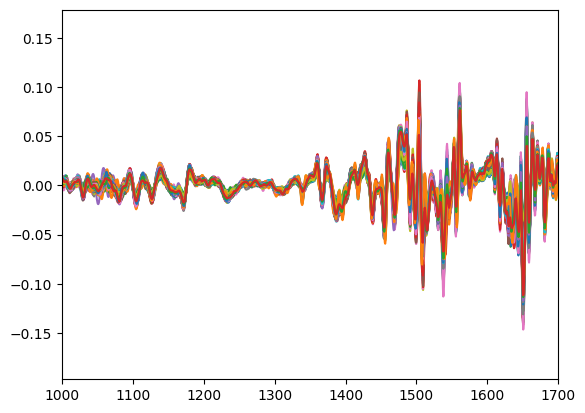

In [6]:
X_deriv = X_raw.T.apply(lambda col: savgol_filter(col, window_length=20, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)
plt.xlim([1000, 1700])


$$V(x; x_0, \sigma, \gamma, A) = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{-\frac{(x - x')^2}{2\sigma^2}} \frac{\gamma}{\pi((x' - x_0)^2 + \gamma^2)} dx'$$

In [7]:
def create_params(x_values, y_values, peaks, initial_values=None):
    params = {}

    params.update({
        "baselinec": dict(value=0.0, min=0, max=0.1, vary=False) 
    })

    for i, peak in enumerate(peaks):
        if initial_values:
            params.update({
                f"v{i+1}amplitude": dict(value=initial_values[f"v{i+1}amplitude"], min=0, vary=True),
                f"v{i+1}center": dict(value=initial_values[f"v{i+1}amplitude"], min=x_values[peak] - 5, max=x_values[peak] + 5, vary=True),
                f"v{i+1}sigma": dict(value=initial_values[f"v{i+1}amplitude"], min=0, vary=True),
                f"v{i+1}gamma": dict(value=initial_values[f"v{i+1}amplitude"], min=0, vary=True)
            })
        else:
            params.update({
                f"v{i+1}amplitude": dict(value=y_values[peak], min=0, vary=True),
                f"v{i+1}center": dict(value=x_values[peak], min=x_values[peak] - 5, max=x_values[peak] + 5, vary=True),
                f"v{i+1}sigma": dict(value=1, min=0, vary=True),
                f"v{i+1}gamma": dict(value=1, min=0, vary=True)
            })
    
    return params
        

def fit_voigt(x_values, y_values, peaks, peak_names=None, initial_values=None):
    peaks = [np.where(x_values == value)[0][0] for value in peaks]
    
    params_dict = create_params(x_values, y_values, peaks, initial_values=initial_values)
    
    model_names = []

    baseline_model = ConstantModel(prefix='baseline')
    composite_model = baseline_model
    
    for i, peak in enumerate(peaks):
        if peak_names:
            model_name = str(peak_names[i])
        else:
            model_name = f"v{i+1}"
        
        voigt_model = VoigtModel(prefix=model_name)
        composite_model += voigt_model
        model_names.append(model_name)

    params = composite_model.make_params(**params_dict)
    result = composite_model.fit(y_values, params, x=x_values)

    fitted_params = result.params
    # for param_name, param in fitted_params.items():
    #     print(param_name, param.value)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Absorbance'))
    fig.add_trace(go.Scatter(x=x_values, y=result.best_fit, mode='lines', name='Best fit', line=dict(color='black')))
    fig.add_trace(go.Scatter(
        x=x_values[peaks],
        y=y_values[peaks],
        mode='markers',
        name='Peaks',
        marker=dict(size=8, color='red'),
        visible='legendonly'
    ))

    comp = result.eval_components(x=x_values)
    
    for key, values in comp.items():
        if key != "baseline":
            fig.add_trace(go.Scatter(x=x_values, 
                                     y=values + result.params['baselinec'].value, 
                                     mode='lines', 
                                     line=dict(width=1, dash='dash'),
                                    name=key))
        else:
            fig.add_trace(go.Scatter(x=x_values, 
                         y=values, 
                         mode='lines', 
                         line=dict(width=1, dash='dash'),
                        name=key))
            

    fig.update_layout(title='Voigt fit', 
                      xaxis_title='Wavenumber', 
                      yaxis_title='Absorbance', 
                      height=650, 
                      width=950
    )
    
    return result, fig

In [8]:
best_values = {
    'v65amplitude': 1.0595968547022494e-11,
    'v65center': 1695.3621028255136,
    'v65sigma': 83.57953511801375,
    'v65gamma': 110.6884768221513,
    'v64amplitude': 7.800649015621275e-12,
    'v64center': 1689.9914250746392,
    'v64sigma': 86.31230012330406,
    'v64gamma': 33.57421459547105,
    'v63amplitude': 1.9761969838327786e-14,
    'v63center': 1687.809709772743,
    'v63sigma': 13.966739036921858,
    'v63gamma': 39.12815247552888,
 'v62amplitude': 1.0313971898767704e-12,
 'v62center': 1678.7374461094637,
 'v62sigma': 7.459215352077457,
 'v62gamma': 1.3796321310334347,
 'v61amplitude': 3.7581317275471804,
 'v61center': 1683.7579990982463,
 'v61sigma': 8.975209440529502,
 'v61gamma': 2.909006369122835e-12,
 'v60amplitude': 4.813591781295401,
 'v60center': 1670.1778278683728,
 'v60sigma': 7.628160828839645,
 'v60gamma': 5.440092820663267e-14,
 'v59amplitude': 1.2265874239499395,
 'v59center': 1667.2392745299223,
 'v59sigma': 0.005064491499111146,
 'v59gamma': 4.065445411378579,
 'v58amplitude': 3.566069557361753,
 'v58center': 1659.8277692155584,
 'v58sigma': 4.057257581405993,
 'v58gamma': 0.5396880337718022,
 'v57amplitude': 1.9573451676210225,
 'v57center': 1656.0807802850907,
 'v57sigma': 0.07566692284527532,
 'v57gamma': 3.812859885125574,
 'v56amplitude': 4.4597854333370055,
 'v56center': 1651.83703715783,
 'v56sigma': 1.2852758659644898,
 'v56gamma': 3.2014302844584837,
 'v55amplitude': 3.270606585349009,
 'v55center': 1647.347133731545,
 'v55sigma': 2.1142231848728623,
 'v55gamma': 2.4724247811597175,
 'v54amplitude': 2.048664636627823,
 'v54center': 1643.3301313504228,
 'v54sigma': 0.022728149491749727,
 'v54gamma': 4.748017628653188,
 'v53amplitude': 4.921825719508057,
 'v53center': 1640.4948614464922,
 'v53sigma': 4.714993264813664,
 'v53gamma': 1.4171188748064178,
 'v52amplitude': 4.472398633636165,
 'v52center': 1635.4057717722924,
 'v52sigma': 4.206476229944411,
 'v52gamma': 4.17350217255548,
 'v51amplitude': 5.630552690569077,
 'v51center': 1630.1510013854818,
 'v51sigma': 3.817581636033136,
 'v51gamma': 4.157820812366475,
 'v50amplitude': 1.2084517408823316,
 'v50center': 1629.1139391523243,
 'v50sigma': 0.30396618120951047,
 'v50gamma': 6.53921211342052,
 'v49amplitude': 2.6849986790878306,
 'v49center': 1624.48067639417,
 'v49sigma': 0.0153036389663892,
 'v49gamma': 5.36558962064563,
 'v48amplitude': 3.836080923585235,
 'v48center': 1619.2246901459798,
 'v48sigma': 1.8670973071260883,
 'v48gamma': 5.015555460547948,
 'v47amplitude': 2.1801653792942495,
 'v47center': 1612.7278142734685,
 'v47sigma': 2.98730560788464,
 'v47gamma': 4.361359663435934,
 'v46amplitude': 4.256227398762244,
 'v46center': 1609.577397929475,
 'v46sigma': 5.194884744848418,
 'v46gamma': 10.619745421169016,
 'v45amplitude': 2.200004492955693,
 'v45center': 1605.433837629067,
 'v45sigma': 9.403392566388558,
 'v45gamma': 16.097144613335647,
 'v44amplitude': 2.140071954468188,
 'v44center': 1602.3958914316775,
 'v44sigma': 7.489457825515494,
 'v44gamma': 0.06064561261914814,
 'v43amplitude': 1.2368437370609957,
 'v43center': 1590.4148645006355,
 'v43sigma': 5.744258746745269,
 'v43gamma': 1.2195348347060864,
 'v42amplitude': 3.292382193649467,
 'v42center': 1584.3156856388573,
 'v42sigma': 9.601240874537588,
 'v42gamma': 17.013016134469286,
 'v41amplitude': 4.871797240186802,
 'v41center': 1579.1273453674034,
 'v41sigma': 5.409093339816865,
 'v41gamma': 13.455011086457679,
 'v40amplitude': 2.0822502841553634,
 'v40center': 1580.9436541826683,
 'v40sigma': 0.29750864932134014,
 'v40gamma': 8.546376500561596,
 'v39amplitude': 1.1883878182918282,
 'v39center': 1573.7582273196917,
 'v39sigma': 0.01303670838033888,
 'v39gamma': 5.620600585653054,
 'v38amplitude': 1.3023991831881503,
 'v38center': 1567.7623603356544,
 'v38sigma': 1.252368219671121,
 'v38gamma': 4.515167395629196,
 'v37amplitude': 1.5774473636747528,
 'v37center': 1562.723697315112,
 'v37sigma': 0.04176147655181239,
 'v37gamma': 4.610000871943215,
 'v36amplitude': 0.8300147911300404,
 'v36center': 1557.6198653016324,
 'v36sigma': 0.28732746907766993,
 'v36gamma': 2.955777924677313,
 'v35amplitude': 3.182226756452473,
 'v35center': 1553.3526568500602,
 'v35sigma': 0.09924351806217357,
 'v35gamma': 5.428321038504811,
 'v34amplitude': 1.8261383709923757,
 'v34center': 1548.5575040066374,
 'v34sigma': 0.02132305540040158,
 'v34gamma': 4.502326876490668,
 'v33amplitude': 4.21954378409748,
 'v33center': 1543.988351864393,
 'v33sigma': 0.05709629991873788,
 'v33gamma': 6.112223999572146,
 'v32amplitude': 3.723888472337018,
 'v32center': 1538.2016944072045,
 'v32sigma': 0.4150318979148935,
 'v32gamma': 5.824706572839459,
 'v31amplitude': 6.6480542603474175,
 'v31center': 1531.3165188198477,
 'v31sigma': 0.02038349672184636,
 'v31gamma': 8.90136634458403,
 'v30amplitude': 5.464811501848106,
 'v30center': 1524.4004394908777,
 'v30sigma': 7.429606201402894,
 'v30gamma': 14.878164060109093,
 'v29amplitude': 2.8146849927935085,
 'v29center': 1517.598137689142,
 'v29sigma': 7.133282445717624,
 'v29gamma': 10.167250403169627,
 'v28amplitude': 1.987421059906282,
 'v28center': 1521.2737965054062,
 'v28sigma': 9.12496446654293,
 'v28gamma': 17.237109042704752,
 'v27amplitude': 9.1335168326609,
 'v27center': 1519.1552545142895,
 'v27sigma': 12.413685658934707,
 'v27gamma': 2.045362093856485,
 'v26amplitude': 8.653562000780834,
 'v26center': 1506.4262417588354,
 'v26sigma': 8.517124304115226,
 'v26gamma': 11.218640080293591,
 'v25amplitude': 9.261782724183389,
 'v25center': 1500.8291797469553,
 'v25sigma': 7.899587148339867,
 'v25gamma': 18.757195240688525,
 'v24amplitude': 0.5358101364943164,
 'v24center': 1497.3360160741938,
 'v24sigma': 3.247083221791236e-05,
 'v24gamma': 5.10360886912989,
 'v23amplitude': 1.256557875491652,
 'v23center': 1489.943995465816,
 'v23sigma': 6.863691833103322,
 'v23gamma': 1.1312680605854468,
 'v22amplitude': 5.721878358589084,
 'v22center': 1468.1547816134168,
 'v22sigma': 1.0679657589529583,
 'v22gamma': 10.889454716662998,
 'v21amplitude': 2.8418784256170424,
 'v21center': 1454.5222441891951,
 'v21sigma': 3.342732876177684,
 'v21gamma': 6.352844156924094,
 'v20amplitude': 7.00666709317815,
 'v20center': 1440.5557479598194,
 'v20sigma': 8.016053990567608,
 'v20gamma': 5.970159562422036,
 'v19amplitude': 5.005645164245172,
 'v19center': 1418.0518611826212,
 'v19sigma': 2.7674131885644435,
 'v19gamma': 13.656822935761623,
 'v18amplitude': 7.312852627855003,
 'v18center': 1401.2875214464311,
 'v18sigma': 0.1631866408232867,
 'v18gamma': 15.59479538678547,
 'v17amplitude': 11.915563845626103,
 'v17center': 1387.4773707787451,
 'v17sigma': 3.8407706042479672,
 'v17gamma': 14.971920777372178,
 'v16amplitude': 4.140635319037998,
 'v16center': 1367.0641504068858,
 'v16sigma': 0.15526912878259624,
 'v16gamma': 14.200115296534543,
 'v15amplitude': 5.376815510852089,
 'v15center': 1343.3996148505307,
 'v15sigma': 0.0009704671032180201,
 'v15gamma': 18.57829059955037,
 'v14amplitude': 11.878214653815727,
 'v14center': 1313.3963904158707,
 'v14sigma': 13.559371710611867,
 'v14gamma': 16.100958860282628,
 'v13amplitude': 10.134398670604822,
 'v13center': 1282.9217140303786,
 'v13sigma': 21.298878764298053,
 'v13gamma': 15.74931616519208,
 'v12amplitude': 11.351239165899479,
 'v12center': 1250.6515622179384,
 'v12sigma': 29.060425515761924,
 'v12gamma': 6.648290269982189,
 'v11amplitude': 9.778997278572614,
 'v11center': 1233.9615140731173,
 'v11sigma': 7.415149000292416,
 'v11gamma': 19.408182053946966,
 'v10amplitude': 4.409897267492723,
 'v10center': 1201.8809927438904,
 'v10sigma': 4.749066122374072,
 'v10gamma': 19.77101929994055,
 'v9amplitude': 2.870547866280631,
 'v9center': 1164.716743258229,
 'v9sigma': 19.375890272969936,
 'v9gamma': 16.593012695140008,
 'v8amplitude': 6.40203946663279,
 'v8center': 1162.7949904232125,
 'v8sigma': 13.721058080716794,
 'v8gamma': 7.090911480917354,
 'v7amplitude': 2.496516267405605,
 'v7center': 1127.0346529549092,
 'v7sigma': 0.08973598483704648,
 'v7gamma': 11.388526647011377,
 'v6amplitude': 5.9756607042257635,
 'v6center': 1107.7833286626883,
 'v6sigma': 4.0930180208418445,
 'v6gamma': 16.54755955162245,
 'v5amplitude': 6.0897864094901815,
 'v5center': 1081.899656892546,
 'v5sigma': 0.05542848449218796,
 'v5gamma': 19.59109039372672,
 'v4amplitude': 10.22228328686234,
 'v4center': 1046.5140000003153,
 'v4sigma': 54.76271275701627,
 'v4gamma': 2.98031226761705,
 'v3amplitude': 2.572213099201602,
 'v3center': 1051.5862367161187,
 'v3sigma': 0.7252737342191209,
 'v3gamma': 22.72460273149078,
 'v2amplitude': 7.941302333428627,
 'v2center': 1029.7209030560487,
 'v2sigma': 26.481584357343024,
 'v2gamma': 52.59544340165838,
 'v1amplitude': 6.134292706196667,
 'v1center': 1015.470337584995,
 'v1sigma': 173.4867818325203,
 'v1gamma': 136.7915018349514,
 'baselinec': 0.10452842407904239
}

In [9]:
X_deriv_5 = X_raw.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=2, deriv=2)).T
X_deriv_5 = X_deriv_5.apply(lambda row: row / np.linalg.norm(row), axis=1)

X_deriv_10 = X_raw.T.apply(lambda col: savgol_filter(col, window_length=10, polyorder=2, deriv=2)).T
X_deriv_10 = X_deriv_10.apply(lambda row: row / np.linalg.norm(row), axis=1)

X_deriv_20 = X_raw.T.apply(lambda col: savgol_filter(col, window_length=20, polyorder=2, deriv=2)).T
X_deriv_20 = X_deriv_20.apply(lambda row: row / np.linalg.norm(row), axis=1)

X_deriv_40 = X_raw.T.apply(lambda col: savgol_filter(col, window_length=40, polyorder=2, deriv=2)).T
X_deriv_40 = X_deriv_40.apply(lambda row: row / np.linalg.norm(row), axis=1)

X_deriv_50 = X_raw.T.apply(lambda col: savgol_filter(col, window_length=50, polyorder=2, deriv=2)).T
X_deriv_50 = X_deriv_50.apply(lambda row: row / np.linalg.norm(row), axis=1)


ranges_1000_1500 = [
    (1005, 1014),
    (1022, 1035),
    (1036, 1048),
    (1050, 1060),
    (1070, 1090),
    (1100, 1110),
    (1120, 1130),
    (1140, 1160),
    (1165, 1180),
    (1185, 1215),
    (1225, 1245),
    (1255, 1270),
    (1275, 1290),
    (1300, 1320),
    (1335, 1345),
    (1360, 1370),
    (1380, 1400),
    (1401, 1405),
    (1410, 1428),
    (1430, 1445),
    (1446, 1458),
    (1465, 1475),
    (1480, 1485),
    (1487, 1495),
    (1496, 1500)
]

ranges_1500_1600 = [
    (1505, 1510),
    (1511, 1515),
    (1516, 1519),
    (1520, 1524),
    (1525, 1529),
    (1530, 1534),
    (1535, 1541),
    (1542, 1545),
    (1546, 1549),
    (1551, 1554),
    (1556, 1559),
    (1561, 1564),
    (1566, 1570),
    (1572, 1576),
    (1576.5, 1580),
    (1581, 1584),
    (1585, 1587),
    (1588, 1592)
    ]

ranges_1600_1700 = [
    (1600, 1603),
    (1604, 1606),
    (1608, 1610),
    (1611, 1614), 
    (1616, 1619), 
    (1622, 1626), 
    (1627, 1630), 
    (1631, 1634),
    (1635, 1638), 
    (1639, 1641), 
    (1643, 1646), 
    (1646.5, 1649), 
    (1650, 1654),
    (1655, 1657),
    (1659, 1663), 
    (1665, 1670), 
    (1672, 1675), 
    (1678, 1680),
    (1681, 1685), 
    (1686, 1689), 
    (1693, 1696), 
    (1698, 1700)
    ]

peaks = []
columns = []


for start, end in ranges_1000_1500: # 1250:2700
    range_data = X_deriv_40.iloc[:, (X_deriv.columns > start) & (X_deriv.columns < end)]
    peak = range_data.idxmin(axis=1)
    peaks.append(peak)
    columns.append(f"{int(start)}-{int(end)}")

for start, end in ranges_1500_1600:
    range_data = X_deriv_5.iloc[:, (X_deriv.columns > start) & (X_deriv.columns < end)]
    peak = range_data.idxmin(axis=1)
    peaks.append(peak)
    columns.append(f"{int(start)}-{int(end)}")

for start, end in ranges_1600_1700:
    range_data = X_deriv_5.iloc[:, (X_deriv.columns > start) & (X_deriv.columns < end)]
    peak = range_data.idxmin(axis=1)
    peaks.append(peak)
    columns.append(f"{int(start)}-{int(end)}")

peaks = pd.DataFrame(np.stack(peaks).T, columns=columns)
peaks

,1005-1014,1022-1035,1036-1048,1050-1060,1070-1090,1100-1110,1120-1130,1140-1160,1165-1180,1185-1215,...,1650-1654,1655-1657,1659-1663,1665-1670,1672-1675,1678-1680,1681-1685,1686-1689,1693-1696,1698-1700
0,1012.462,1029.336,1047.657,1050.067,1079.959,1105.030,1126.243,1159.992,1169.634,1204.829,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
1,1011.497,1028.854,1047.657,1054.406,1081.888,1105.030,1125.761,1159.992,1169.634,1204.829,...,1652.241,1656.098,1660.919,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
2,1013.426,1029.818,1047.657,1051.996,1081.888,1104.547,1125.761,1158.063,1169.152,1206.758,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
3,1011.015,1029.336,1047.657,1050.550,1080.441,1104.547,1125.761,1159.992,1169.634,1205.312,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
4,1012.944,1030.300,1047.657,1050.067,1079.959,1105.030,1125.279,1157.581,1169.152,1204.347,...,1652.241,1656.098,1660.919,1667.669,1673.937,1678.758,1683.097,1687.436,1694.668,1699.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,1011.497,1029.336,1047.657,1050.067,1080.441,1105.030,1126.243,1158.063,1169.634,1206.758,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
290,1011.980,1028.372,1047.657,1051.514,1079.477,1105.030,1126.243,1159.510,1169.634,1206.758,...,1652.241,1656.098,1660.437,1667.669,1674.419,1679.240,1683.097,1687.436,1694.668,1699.007
291,1011.015,1029.336,1047.657,1051.032,1080.923,1105.030,1126.243,1159.992,1169.634,1207.722,...,1652.241,1656.098,1661.401,1668.151,1674.419,1679.240,1683.579,1688.400,1694.668,1699.489
292,1011.980,1029.336,1047.657,1050.067,1079.477,1105.030,1125.761,1158.063,1169.634,1204.347,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007


In [ ]:
%%time
sample_raw = X.iloc[0, 1250:2700]
x_values = sample_raw.index.to_numpy()
y_values = sample_raw.to_numpy()
idx = peaks.iloc[0]
res, fig = fit_voigt(x_values, y_values, idx)

In [ ]:
fig.show()